In [1]:
import pandas as pd
import sqlite3

# Loading the dummy CDR into a database

In [2]:
# read the dumm CDR
cdr = pd.read_csv("dummy_data/cdr.csv")

# create in-memory database
db = sqlite3.connect(":memory:")

# drop the cdr table if already exists
db.execute("DROP TABLE IF EXISTS cdr")

# load dummy CDR to the in-memory database
cdr.to_sql("cdr", db)

2279095

# Executing the queries

Please note that this notebook uses sqlite, but in the study PostgreSQL was used. The PostgreSQL dialects of these queries are also included in this repository.

## Home

```sql
SELECT
    device_id, cell_id, count(*) AS count
FROM
    cdr
WHERE
(
        -- weekends, 0 is Sunday, 6 is Saturday
        mod(cast(strftime("%w", cdr.timestamp) AS INT), 6) = 0
    OR
        -- Good Friday
        date(cdr.timestamp) = '2017-04-14'
    OR
        -- Easter Monday
        date(cdr.timestamp) = '2017-04-17'
    )
OR
    (
        -- weekdays, 0 is Sunday, 6 is Saturday
        mod(cast(strftime("%w", cdr.timestamp) AS INT), 6) > 0
    AND
        -- Good Friday
        date(cdr.timestamp) != '2017-04-14'
    AND
        -- Easter Monday
        date(cdr.timestamp) != '2017-04-17'
    AND
        (
            time(cdr.timestamp) >= '22:00:00'
        OR
            time(cdr.timestamp) <= '06:00:00'
        )
    )
GROUP BY
    device_id, cell_id
ORDER BY
    device_id, count DESC;
```

In [3]:
with open("home_and_work_detection/home.sqlite.sql") as fp:
    home_sql = fp.read()

most_frequent_weekend_and_night_cells = pd.read_sql(home_sql, db)


## Work

```sql
SELECT
    device_id, cell_id, count(*) AS count
FROM
    cdr
WHERE
    -- weekdays, 0 is Sunday, 6 is Saturday
    mod(cast(strftime("%w", cdr.timestamp) AS INT), 6) > 0
AND
    -- Good Friday
    date(cdr.timestamp) != '2017-04-14'
AND
    -- Easter Monday
    date(cdr.timestamp) != '2017-04-17'
AND
    time(cdr.timestamp) >= '09:00:00'
AND
    time(cdr.timestamp) <= '16:00:00'
GROUP BY
    device_id, cell_id
ORDER BY
    device_id, count DESC;
```

In [4]:

with open("home_and_work_detection/work.sqlite.sql") as fp:
    work_sql = fp.read()

most_frequent_weekday_workhour_cells = pd.read_sql(work_sql, db)

# Selecting the most frequent home and work candidate

In [5]:
home = most_frequent_weekend_and_night_cells.drop_duplicates(subset="device_id", keep="first").reset_index(drop=True).copy()

home["total"] = most_frequent_weekend_and_night_cells.groupby("device_id")["count"].sum().tolist()
home["certainty"] = home["count"] / home["total"]


In [6]:
work = most_frequent_weekday_workhour_cells.drop_duplicates(subset="device_id", keep="first").reset_index(drop=True).copy()

work["total"] = most_frequent_weekday_workhour_cells.groupby("device_id")["count"].sum().tolist()
work["certainty"] = work["count"] / work["total"]


# Printing the result

In [7]:
# merge
hw = home.merge(work, on="device_id", how="outer", suffixes=["_work", "_home"])
hw

,device_id,cell_id_work,count_work,total_work,certainty_work,cell_id_home,count_home,total_home,certainty_home
0,1,2749618,3,87,0.034483,2082758.0,2.0,66.0,0.030303
1,2,667986,2,46,0.043478,2743054.0,1.0,34.0,0.029412
2,3,2749618,2,105,0.019048,2738118.0,2.0,81.0,0.024691
3,4,738684,6,246,0.024390,51256.0,5.0,195.0,0.025641
4,5,2749618,2,44,0.045455,2747090.0,1.0,32.0,0.031250
...,...,...,...,...,...,...,...,...,...
9982,9996,2749618,5,215,0.023256,10314.0,4.0,148.0,0.027027
9983,9997,2702588,1,5,0.200000,2738127.0,1.0,5.0,0.200000
9984,9998,2697628,1,24,0.041667,731888.0,2.0,21.0,0.095238
9985,9999,2749618,3,90,0.033333,731888.0,2.0,68.0,0.029412


# Mapping cells to districts

In [8]:
import geopandas as gpd
from shapely import wkt

/usr/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [9]:
# load shapefile, downloaded from OSM, enriched with information as district group and agglomeration sector
bp = gpd.read_file("input/budapest_border.geojson", crs=4326)
cities = gpd.read_file("input/cities_with_labels.geojson", crs=4326)

cells = pd.read_csv("dummy_data/cells.csv")
cells["geometry"] = cells["geometry"].apply(wkt.loads)
cells = gpd.GeoDataFrame(cells, geometry="geometry", crs=4326)
cells.rename({"cid": "cell_id"}, axis=1, inplace=True)

# map cells to districts or settlements
cells = cells.sjoin(cities, how="left")

In [10]:
cells

,radio,mcc,mnc,lac,cell_id,lon,lat,range,samples,created,updated,geometry,index_right,osm_id,name,city,sector,district_group,city_part,did
0,GSM,216,70,141,12142,19.284950,47.297036,39621,1999,1317853422,1515062886,POINT (19.28495 47.29704),86.0,214784,Ócsa,ocsa,south_eastern,None,None,None
1,GSM,216,70,141,12151,19.269680,47.343904,25773,383,1317853422,1515063475,POINT (19.26968 47.34390),63.0,214782,Felsőpakony,felsopakony,south_eastern,None,None,None
2,GSM,216,70,141,14765,19.277820,47.285802,22136,1188,1317853422,1618193051,POINT (19.27782 47.28580),86.0,214784,Ócsa,ocsa,south_eastern,None,None,None
3,GSM,216,70,141,12152,19.291631,47.297692,11950,1204,1317854261,1515062696,POINT (19.29163 47.29769),86.0,214784,Ócsa,ocsa,south_eastern,None,None,None
4,GSM,216,70,141,14764,19.224429,47.341574,22578,1462,1317854261,1571281991,POINT (19.22443 47.34157),20.0,1385739,Gyál,gyal,south_eastern,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3987,UMTS,216,70,235,2698548,19.155275,47.605460,1969,390,1613229242,1640668373,POINT (19.15527 47.60546),22.0,214931,Fót,fot,northern,None,None,None
3988,UMTS,216,70,3111,267276,18.934753,47.459028,3809,327,1621498140,1648376182,POINT (18.93475 47.45903),39.0,113463,Budaörs,budaors,western,None,None,None
3989,UMTS,216,70,3111,447500,18.932141,47.457515,1276,297,1621498243,1647764986,POINT (18.93214 47.45752),39.0,113463,Budaörs,budaors,western,None,None,None
3990,UMTS,216,70,3115,454155,19.042941,47.466129,944,390,1632393634,1653712405,POINT (19.04294 47.46613),71.0,221998,11. kerület,bp_11,None,south-buda,inner,11


## Merging settlement information to the detected home-work location DataFrame 

In [11]:
cells_for_home = cells[["cell_id", "lon", "lat", "geometry", "city", "sector", "district_group"]].copy()
cells_for_home.columns = [i+"_home" for i in cells_for_home.columns]
cells_for_work = cells[["cell_id", "geometry", "lon", "lat", "city", "sector", "district_group"]].copy()
cells_for_work.columns = [i+"_work" for i in cells_for_work.columns]

merged = hw.merge(cells_for_home, on="cell_id_home", how="left")\
           .merge(cells_for_work, on="cell_id_work", how="left")

In [12]:
merged

,device_id,cell_id_work,count_work,total_work,certainty_work,cell_id_home,count_home,total_home,certainty_home,lon_home,...,geometry_home,city_home,sector_home,district_group_home,geometry_work,lon_work,lat_work,city_work,sector_work,district_group_work
0,1,2749618,3,87,0.034483,2082758.0,2.0,66.0,0.030303,19.155262,...,POINT (19.15526 47.71823),szodliget,northern,None,POINT (19.11704 47.53163),19.117037,47.531626,bp_14,None,eastern-pest_inner
1,2,667986,2,46,0.043478,2743054.0,1.0,34.0,0.029412,18.968748,...,POINT (18.96875 47.77106),visegrad,north_western,None,POINT (19.10315 47.48817),19.103152,47.488165,bp_8,None,inner-pest
2,3,2749618,2,105,0.019048,2738118.0,2.0,81.0,0.024691,19.154384,...,POINT (19.15438 47.71111),god,northern,None,POINT (19.11704 47.53163),19.117037,47.531626,bp_14,None,eastern-pest_inner
3,4,738684,6,246,0.024390,51256.0,5.0,195.0,0.025641,19.337478,...,POINT (19.33748 47.59498),godollo,eastern,None,POINT (19.00867 47.49683),19.008669,47.496834,bp_12,None,north-buda
4,4,738684,6,246,0.024390,51256.0,5.0,195.0,0.025641,19.344040,...,POINT (19.34404 47.58780),godollo,eastern,None,POINT (19.00867 47.49683),19.008669,47.496834,bp_12,None,north-buda
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11683,9996,2749618,5,215,0.023256,10314.0,4.0,148.0,0.027027,19.105231,...,POINT (19.10523 47.51570),bp_14,None,eastern-pest_inner,POINT (19.11704 47.53163),19.117037,47.531626,bp_14,None,eastern-pest_inner
11684,9997,2702588,1,5,0.200000,2738127.0,1.0,5.0,0.200000,19.165791,...,POINT (19.16579 47.66910),god,northern,None,POINT (19.11602 47.54371),19.116023,47.543709,bp_15,None,eastern-pest_outer
11685,9998,2697628,1,24,0.041667,731888.0,2.0,21.0,0.095238,19.087592,...,POINT (19.08759 47.51948),bp_14,None,eastern-pest_inner,POINT (19.14061 47.54559),19.140612,47.545592,bp_15,None,eastern-pest_outer
11686,9999,2749618,3,90,0.033333,731888.0,2.0,68.0,0.029412,19.087592,...,POINT (19.08759 47.51948),bp_14,None,eastern-pest_inner,POINT (19.11704 47.53163),19.117037,47.531626,bp_14,None,eastern-pest_inner


## Calculating the detected population by settlements

In [13]:
population = merged.groupby("city_home")["device_id"].count().reset_index()
population.columns = ["city", "count"]

In [14]:
population

,city,count
0,alsonemedi,3
1,biatorbagy,17
2,bp_1,56
3,bp_10,141
4,bp_11,144
...,...,...
81,vacratot,14
82,vecses,17
83,veresegyhaz,27
84,visegrad,69


In [15]:
cities = cities.merge(population, on="city", how="left")

# Generating Figure 7

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter


def thousand_format(x, p):
    return format(int(x), ",") if int(x) >= 10000 else int(x)


Note that the `vmax` is adjusted to the dummy data. Also, the code only demonstrates the figure plotting, so the result does not mean anything.

(18.680802993, 19.469559507, 47.201914304000006, 47.856988496)

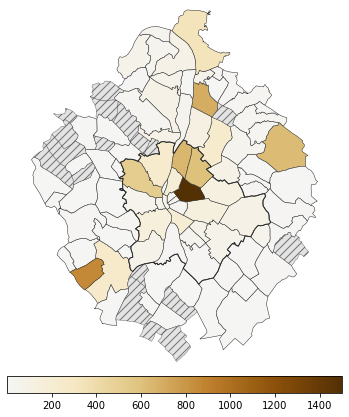

In [17]:
cmap_br = ListedColormap(sns.color_palette("BrBG_r", 256)[128:], N=128)

legend_kwds = {"orientation": "horizontal", "pad": 0.025,
               "format": FuncFormatter(thousand_format)}
missing = {
    "color": "#e3e3e3",
    "edgecolor": "#2d2d2dA0",
    "hatch": "///",
    "label": "Missing values"}
fig, ax = plt.subplots(figsize=(6, 8))
cities.plot(column="count", cmap=cmap_br, edgecolor="#2d2d2d", ax=ax,
            linewidth=.5, missing_kwds=missing, legend=True, vmax=1500,
            legend_kwds=legend_kwds)

bp.plot(ax=ax, color="none", edgecolor="#2d2d2d", linewidth=1, zorder=10)
ax.margins(.01)
ax.axis("off")

# Generating Figure 9

In [18]:
def plot_fig9(df, city, cmap, bp, without_locals=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))
    query = "city_home == @city"
    title = f"workers of {city}"
    if without_locals:
        title += ", without locals"
        query += " & city_home != city_work"
    sns.kdeplot(data=df.query(query), x="lon_work", y="lat_work",
                levels=6, fill=True, cmap=cmap, ax=ax)
    bp.geometry.boundary.plot(color=None, linewidth=1, ax=ax,
                              edgecolor="#2d2d2d")
    cities.query("city == @city").geometry.boundary\
          .plot(color=None, linewidth=1, ax=ax, edgecolor="#2d2d2d")
    ax.axis("off")
    ax.margins(0)
    ax.set_title(title)
    if not ax:
        return ax.get_figure(), ax


c256 = sns.color_palette("BrBG_r", 256)
cmap_br_fig_9 = ListedColormap(c256[152:])
cmap_bg_fig_9 = ListedColormap(c256[::-1][152:])

In [19]:
merged.query("city_home == 'bp_14'")[["device_id", "city_home", "city_work"]]

,device_id,city_home,city_work
6,6,bp_14,bp_14
7,6,bp_14,bp_14
8,7,bp_14,bp_14
13,12,bp_14,bp_14
14,13,bp_14,bp_12
...,...,...,...
11681,9995,bp_14,bp_14
11682,9996,bp_14,bp_14
11683,9996,bp_14,bp_14
11685,9998,bp_14,bp_15


In [20]:
merged.query("city_home==city_work")

,device_id,cell_id_work,count_work,total_work,certainty_work,cell_id_home,count_home,total_home,certainty_home,lon_home,...,geometry_home,city_home,sector_home,district_group_home,geometry_work,lon_work,lat_work,city_work,sector_work,district_group_work
6,6,2749618,5,43,0.116279,10314.0,3.0,33.0,0.090909,19.102747,...,POINT (19.10275 47.51460),bp_14,None,eastern-pest_inner,POINT (19.11704 47.53163),19.117037,47.531626,bp_14,None,eastern-pest_inner
7,6,2749618,5,43,0.116279,10314.0,3.0,33.0,0.090909,19.105231,...,POINT (19.10523 47.51570),bp_14,None,eastern-pest_inner,POINT (19.11704 47.53163),19.117037,47.531626,bp_14,None,eastern-pest_inner
8,7,2749618,7,275,0.025455,731888.0,3.0,206.0,0.014563,19.087592,...,POINT (19.08759 47.51948),bp_14,None,eastern-pest_inner,POINT (19.11704 47.53163),19.117037,47.531626,bp_14,None,eastern-pest_inner
13,12,2749618,2,31,0.064516,2701514.0,1.0,23.0,0.043478,19.107611,...,POINT (19.10761 47.51728),bp_14,None,eastern-pest_inner,POINT (19.11704 47.53163),19.117037,47.531626,bp_14,None,eastern-pest_inner
19,18,2749618,4,77,0.051948,731888.0,3.0,56.0,0.053571,19.087592,...,POINT (19.08759 47.51948),bp_14,None,eastern-pest_inner,POINT (19.11704 47.53163),19.117037,47.531626,bp_14,None,eastern-pest_inner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11680,9994,2699429,1,9,0.111111,2749619.0,1.0,9.0,0.111111,19.104343,...,POINT (19.10434 47.53542),bp_14,None,eastern-pest_inner,POINT (19.11547 47.52978),19.115468,47.529778,bp_14,None,eastern-pest_inner
11681,9995,2749618,6,190,0.031579,731888.0,3.0,135.0,0.022222,19.087592,...,POINT (19.08759 47.51948),bp_14,None,eastern-pest_inner,POINT (19.11704 47.53163),19.117037,47.531626,bp_14,None,eastern-pest_inner
11682,9996,2749618,5,215,0.023256,10314.0,4.0,148.0,0.027027,19.102747,...,POINT (19.10275 47.51460),bp_14,None,eastern-pest_inner,POINT (19.11704 47.53163),19.117037,47.531626,bp_14,None,eastern-pest_inner
11683,9996,2749618,5,215,0.023256,10314.0,4.0,148.0,0.027027,19.105231,...,POINT (19.10523 47.51570),bp_14,None,eastern-pest_inner,POINT (19.11704 47.53163),19.117037,47.531626,bp_14,None,eastern-pest_inner


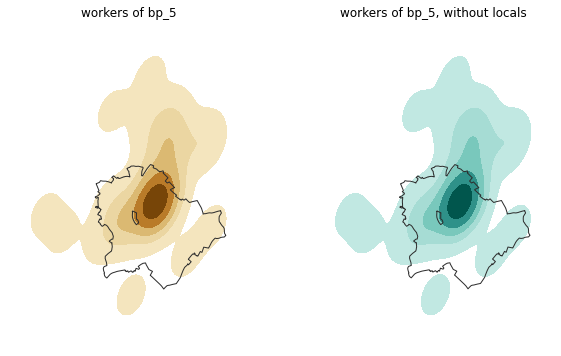

In [21]:
fig9, axs9 = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
plot_fig9(merged, "bp_5", cmap_br_fig_9, bp, ax=axs9[0])
plot_fig9(merged, "bp_5", cmap_bg_fig_9, bp, without_locals=True, ax=axs9[1])


# Generating Figure 10

In [22]:
import numpy as np
from mne_connectivity.viz import plot_connectivity_circle as chord
from collections import Counter
from matplotlib.colors import ListedColormap

c256 = sns.color_palette("BrBG_r", 256)
cmap_br = ListedColormap(c256[128:])
cdg = sns.color_palette("BrBG", 10)


buda = [1, 2, 3, 12, 11, 22]
pest = [4, 13, 5, 6, 7, 8, 10, 14, 15, 16, 17, 18, 19, 9, 20, 21, 23]
gcolors = {"eastern-pest_inner": cdg[6],
           "eastern-pest_outer": cdg[5],
           "inner-pest": cdg[7],
           "north-buda": cdg[3],
           "north-pest": cdg[9],
           "south-buda": cdg[2],
           "south-pest": cdg[1]}
node_colors = [gcolors["north-buda"]]*4 + [gcolors["south-buda"]]*2 +\
               [gcolors["north-pest"]]*2 + [gcolors["inner-pest"]]*4 +\
               [gcolors["eastern-pest_inner"]]*2 +\
               [gcolors["eastern-pest_outer"]]*5 + [gcolors["south-pest"]]*4

glabels = {"inner-pest": "Inner Pest",
           "south-pest": "South Pest", "north-buda": "North Buda",
           "north-pest": "North Pest", "south-buda": "South Buda",
           "eastern-pest_inner": "Eastern Pest (inner)",
           "eastern-pest_outer": "Eastern Pest (outer)"}

artists = []
labels = []
for i in ["inner-pest", "eastern-pest_outer", "north-buda",
          "eastern-pest_inner", "north-pest", "south-buda", "south-pest"]:
    artists.append(plt.Circle((0, 1), (0, 0), facecolor=gcolors[i],
                   edgecolor="#2d2d2d"))
    labels.append(glabels[i])


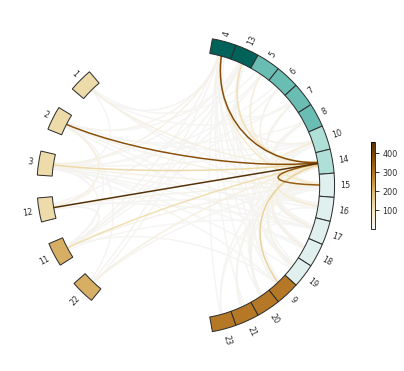

In [23]:
dd = merged[["city_home", "city_work"]].query("city_home.str.startswith('bp_')"
                                              " & city_work.str.startswith('bp_')"
                                              " & city_home != 'bp_margitsziget'"
                                              " & city_work != 'bp_margitsziget'")
dd["city_home"] = dd["city_home"].apply(lambda x: int(x[3:]))
dd["city_work"] = dd["city_work"].apply(lambda x: int(x[3:]))

con_mx = pd.pivot_table(dd, index=["city_work"], columns=["city_home"],
                        aggfunc=len)

con_mx = con_mx.reindex(buda+pest)[buda+pest]
h2w = dd.apply(lambda x: f"h{x['city_home']:02d}->w{x['city_work']:02d}",
               axis=1)
Counter(sorted(h2w))

a = con_mx.values
b = con_mx.copy().values
np.fill_diagonal(b, 0)
b = np.transpose(b)

c = a+b
# c = np.where(c >= 250, c, np.nan)

node_names = con_mx.index
# %%
# https://www.python-graph-gallery.com/406-chord-diagram_mne
first_half = (np.linspace(45, 136, 6) + 90).astype(float)[::+1] % 360
second_half = (np.linspace(15, 165, 17) - 90).astype(float)[::-1] % 360
node_angles = np.array(list(first_half) + list(second_half))

# %%
fig, axes = chord(c, node_names, node_angles=node_angles,
                  node_colors=node_colors, node_edgecolor="#2d2d2d",
                  node_linewidth=1, colorbar_pos=(-0.25, 0.5), padding=2,
                  colormap=cmap_br, facecolor="white", textcolor="#2d2d2d")

axes.legend(artists, labels, bbox_to_anchor=(1, 1))

# Generating Figure 12

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

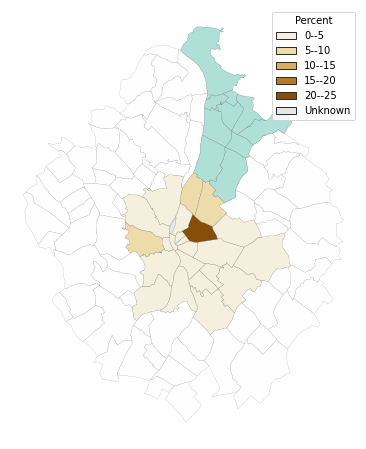

In [24]:
from matplotlib.patches import Patch
import yaml

with open("input/sector_settlements.yaml") as fp:
    sectors = yaml.safe_load(fp)


def plot_sector_targets(data: pd.DataFrame, sector: list,
                        axes=None,
                        agglomeration: bool = True, legend_loc: str = "best"):
    dest = data.query("city_home.isin(@sector)")\
               .groupby("city_work")["device_id"].count().reset_index()
    dest.columns = ["city", "count"]
    dest = dest.query("city.str.startswith('bp_')").copy()
    dest["count"] = np.round(dest["count"] / dest["count"].sum() * 100, 2)
    cities = gpd.read_file("input/cities_with_labels.geojson", crs=4326)
    df = cities.query("city.str.startswith('bp_')")

    df = df.merge(dest, on="city", how="left")

    fig, ax = plt.subplots(figsize=(8, 8))
    if axes is not None:
        ax = axes
        fig = axes.get_figure()
    bins = [0, 6, 12, 18, 24]
    bins = [0, 5, 10, 15, 20, 25]
    palette = sns.color_palette("BrBG_r", 10)
    cmap = ListedColormap(palette[5:])
    df.plot(ax=ax, column="count", cmap=cmap, scheme="user_defined",
            edgecolor="#2d2d2d", linewidth=0.15, legend=False,
            legend_kwds={"loc": legend_loc},
            classification_kwds={"bins": bins},
            missing_kwds={"color": "#e7e7e7", "label": "Missing values"}
            )

    if agglomeration:
        cities.query("~city.str.startswith('bp_') & ~city.isin(@sector)")\
              .plot(ax=ax, color="#fefefe", edgecolor="#2d2d2d", linewidth=0.1)
    cities.query("city.isin(@sector)")\
          .plot(ax=ax, color=palette[3], edgecolor="#2d2d2d",
                linewidth=0.15)

    legend_elements = []
    for i, e in enumerate(bins[:-1]):
        patch = Patch(fc=palette[5+i], ec="#2d2d2d", label=f"{e}--{e+5}")
        legend_elements.append(patch)
    legend_elements.append(Patch(fc="#e7e7e7", ec="#2d2d2d",
                                 label="Unknown"))
    if legend_loc:
        legend = ax.legend(handles=legend_elements, ncol=1)

        legend.set_title("Percent")
    ax.axis("off")
    if axes is None:
        return fig, ax


plot_sector_targets(merged, sectors["northern"])

# Generating Figure 13

In [25]:
from matplotlib.ticker import PercentFormatter, FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
from shapely.geometry import Polygon


cities_gdf = gpd.read_file("input/cities_with_labels.geojson", crs=4326)
cities_gdf.to_crs(23700, inplace=True)
duna = gpd.read_file("input/duna.geojson", crs=23700)
duna["is_polygon"] = duna["geometry"].apply(isinstance, args=(Polygon,))
minX = 630000
maxX = 680000
minY = 215000
maxY = 275000
clip_area = Polygon([(minX, minY), (maxX, minY), (maxX, maxY),
                     (minX, maxY), (minX, minY)])

In [26]:
def prepare_to_plot(df, city, ref_table):
    filtered = df[df["city_home"] == city]\
              .groupby("district_group")["device_id"].count().reset_index()
    filtered.columns = ["district_group", "count"]

    count = filtered["count"].sum()
    filtered["ratio"] = filtered["count"] / filtered["count"].sum()

    counted = filtered.drop("count", axis=1)
    counted.columns = ["district_group", "2017 (CDR)"]

    merged = ref_table.merge(counted, on="district_group")

    pearsonr = merged["2011"].corr(merged["2017 (CDR)"], method="pearson")

    melted = pd.melt(merged, id_vars=["district_group"],
                     value_vars=["1990", "2001", "2011", "2017 (CDR)"])
    melted["district_group"] = melted["district_group"].map(glabels)
    return melted, pearsonr, count


def plot_bar(df, figsize=(8, 5), legend_loc="upper left"):
    data = df.copy()
    colors = sns.color_palette("BrBG", 8)
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(data=data, x="district_group", y="value", ax=ax,
                hue="variable", palette=colors[0:3][::-1]+[colors[7]])
    ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
    ax.tick_params(axis="x", labelrotation=30)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(*ax.get_legend_handles_labels(), loc=legend_loc)
    ax.get_legend().set_title("")
    return fig, ax


def plot_map(city: str, ax=None):
    color = sns.color_palette("BrBG", 8)
    f, a = plt.subplots(figsize=(5, 6))
    if ax:
        a = ax
        f = a.get_figure()
    c = cities_gdf.query("city == @city")
    bp.to_crs(23700).boundary.plot(ax=a, color="#2d2d2d90", linewidth=.9, zorder=1)
    c.plot(ax=a, color=color[1], edgecolor=color[1], zorder=5)
    a.margins(0)
    a.axis("off")
    a.set_xlim(630000, 680000)
    a.set_ylim(215000, 275000)
    frame = Rectangle((630000, 215000), 50000, 60000, linewidth=2,
                      fill=False, ec="#d6d6d6")

    a.add_patch(frame)
    gpd.clip(duna.query("is_polygon"), clip_area)\
       .plot(ax=a, zorder=0, color=color[6])
    if not ax:
        return f, a


Note that the reference values are set to constant only to demonstrate the plotting with the dummy mobile network data.

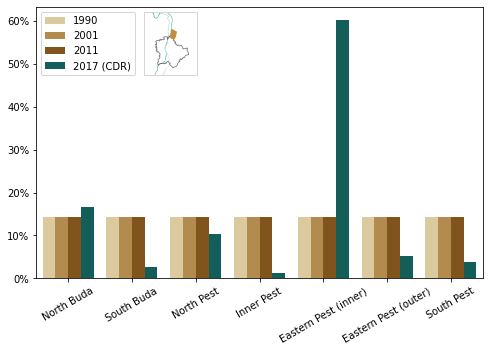

In [27]:
census_dunakeszi = pd.DataFrame({"district_group": ["north-buda", "south-buda", "north-pest", "inner-pest", "eastern-pest_inner", "eastern-pest_outer", "south-pest"], "1990": [1/7]*7, "2001": [1/7]*7, "2011": [1/7]*7})

city = "dunakeszi"
melted, pearsonr, count = prepare_to_plot(merged.rename({"district_group_work": "district_group"}, axis=1), city, census_dunakeszi)
fig, ax = plot_bar(melted)

iax = inset_axes(ax, width=.9, height=.9,  # inch
                 bbox_transform=ax.transAxes,  # relative axes coordinates
                 bbox_to_anchor=(0.385, 1))

plot_map(city, ax=iax)

%matplotlib inline
fig.set_facecolor("white")
fig

# Generating Figure 14

In [28]:
def label_sectors(x: str, labels: dict) -> str:
    if x.startswith("bp_") or x == "":
        return np.NaN
    return labels[x]


with open("input/sector_settlements.yaml") as fp:
    sector = yaml.safe_load(fp)

sector_labels = {i: k for k, v in sectors.items() for i in v}
xticklabels = ["Southern", "Southeastern", "Eastern",  "Northern",
               "Northwestern", "Western", "Summarized"]
browns = sns.color_palette("BrBG_r", 12)[6:]

devices = pd.read_csv("dummy_data/device.csv")
    
fig11_data = merged.merge(devices, on="device_id").dropna(subset=["city_work"]).copy()
fig11_data["city_home"] = fig11_data["city_home"].fillna("")

In [29]:
fig11_data.dropna(subset=["city_work"], inplace=True)
fig11_data["age"] = pd.to_numeric(fig11_data["age"], downcast="integer")
bins = list(range(20, 70, 10)) + [100]
labels = ["20-29", "30-39", "40-49", "50-59", "60+"]
fig11_data["age_group"] = pd.cut(fig11_data["age"], bins=bins, labels=labels)
fig11_data["sector_home"] = fig11_data["city_home"].apply(label_sectors,
                                                          labels=sector_labels)

r2t1 = pd.pivot_table(fig11_data, index="age_group", columns="sector_home",
                      values="device_id", aggfunc=np.size)
r2t1["all"] = r2t1["southern"] + r2t1["south_eastern"] + r2t1["eastern"]\
            + r2t1["northern"] + r2t1["north_western"] + r2t1["western"]

for i in r2t1.columns.tolist():
    r2t1[i] = round(r2t1[i] / r2t1[i].sum() * 100, 1)

In [30]:
r2t1_melted = r2t1.reset_index().melt(
    id_vars=["age_group"],
    value_vars=["southern", "south_eastern", "eastern", "northern",
                "north_western", "western", "all"],
    var_name="sector")

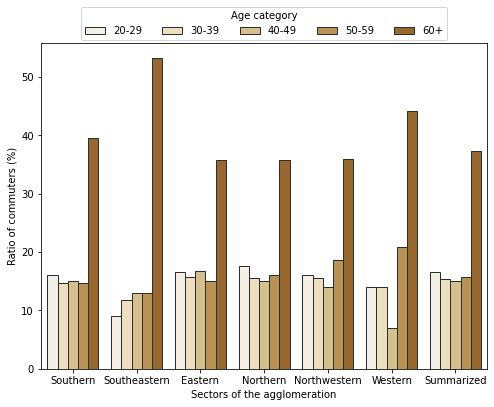

In [31]:
r2t1_fig, r2t1_ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=r2t1_melted, x="sector", y="value", ax=r2t1_ax,
            hue="age_group", palette=browns, edgecolor="#2d2d2d")
r2t1_ax.set_ylabel("Ratio of commuters (%)")
r2t1_ax.set_xlabel("Sectors of the agglomeration")
r2t1_ax.set_xticklabels(xticklabels)

r2t1_ax.legend(title="Age category",
               loc="upper center", bbox_to_anchor=(0.5, 1.125), ncol=5)